# Scraping Game Reviews

For this project, we'll scrape data from metacritic in order to try and see which games may be worth playing under quarantine...

## Import libraries

In [24]:
#For data wrangling
import pandas as pd
import numpy as np
from scipy import stats
import copy

#For webscraping
from bs4 import BeautifulSoup
import requests
import re
import datetime
import time

#For data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PythonFunctions.cb91visuals import *
from matplotlib_venn import venn3, venn3_circles

import pickle

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_games_by_platform_and_letter(platform,letter):
    
    #Get the page URL, according to the platform and starting letter
    url = f'https://www.metacritic.com/browse/games/title/{platform}/{letter}?page=0'
    headers = {'User-Agent':
           'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
    
    #Request the URL, and make soup from the HTML
    page = requests.get(url, headers = headers)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    #Isolate the page links, which will tell us how many pages we have of this letter
    pagelinks = soup.find('div', class_="pages")
    
    #Get the number of the last page, so we can set a sensible loop later on
    try:
        last_page = int(pagelinks.find('li', class_="page last_page").get_text().replace('…',''))
    except:
        last_page = 0
    
    #Instantiate a dataframe
    df = pd.DataFrame()
    
    #Possible platforms
    plats = {'xboxone':'(XONE)',
            'ps4':'(PS4)',
            'switch':'(Switch)',
            'pc':'(PC)'}
    
    for i in list(range(max(1,last_page))):
        
        if letter == '#':
            url = f'https://www.metacritic.com/browse/games/title/{platform}?page={i}'
        else:
            url = f'https://www.metacritic.com/browse/games/title/{platform}/{letter}?page={i}'
        
        print(url)
        
        #Find the page, and get the HTML soup for that page
        page = requests.get(url, headers = headers)
        soup = BeautifulSoup(page.content, 'html.parser')
        
        #Get the games HTML
        games_html = soup.find(
            'ol', class_="list_products").find_all(
            'div', class_='product_wrap')
        
        #Get game titles
        titles = [i.find('div',
                         class_="basic_stat").get_text(
        ).replace('\n','').replace('  ','').replace(plats[platform],'').strip()
                  for i in games_html]
        
        platforms = [platform for i in games_html]
        
        metaratings = [i.find('div', class_="metascore_w").get_text() for i in games_html]
        
        userratings = [i.find_all('span', class_='data')[0].get_text() for i in games_html]
        
        releasedates = [i.find_all('span', class_='data')[1].get_text().strip(
        ).replace('  ',' ') for i in games_html]
        
        gameurls =  [i.find('a').attrs['href'] for i in games_html]
        
        new_df = pd.DataFrame({'GameTitle':titles,
                               'Platform':platforms,
                               'MetaRating':metaratings,
                               'UserRating':userratings,
                               'ReleaseDate':releasedates,
                               'GameURL':gameurls})
        
        df = pd.concat([df, new_df])
        
        time.sleep(round(2*np.random.random(),2))
    
    df.reset_index(inplace=True, drop=True)
    
    return df


def get_games(platforms=['xboxone','ps4','switch','pc'],
              letters=list('#abcdefghijklmnopqrstuvwxyz')):
    '''
    Populates tables for a given list of platforms and letters
    '''
    
    #Instantiate a dataframe
    
    df = pd.DataFrame()
    
    for platform in platforms:
        for letter in letters:
            new_rows = get_games_by_platform_and_letter(platform,letter)
            df = pd.concat([df,new_rows])
            
            
    df.reset_index(inplace=True, drop=True)
    return df

In [3]:
# df_ps4 = get_games(platforms=['ps4'])

# with open('Dataframes/df_ps4.pickle', 'wb') as f:
#     pickle.dump(df_ps4, f, pickle.HIGHEST_PROTOCOL)
    
with open('Dataframes/df_ps4.pickle', 'rb') as f:
    df_ps4 = pickle.load(f)

In [4]:
# df_xbox = get_games(platforms=['xboxone'])

# with open('Dataframes/df_xbox.pickle', 'wb') as f:
#     pickle.dump(df_xbox, f, pickle.HIGHEST_PROTOCOL)
    
with open('Dataframes/df_xbox.pickle', 'rb') as f:
    df_xbox = pickle.load(f)

In [5]:
# df_switch = get_games(platforms=['switch'])

# with open('Dataframes/df_switch.pickle', 'wb') as f:
#     pickle.dump(df_switch, f, pickle.HIGHEST_PROTOCOL)
    
with open('Dataframes/df_switch.pickle', 'rb') as f:
    df_switch = pickle.load(f)

In [6]:
df = pd.concat([df_ps4, df_xbox, df_switch])

df_score = df.loc[df['MetaRating']!='tbd']
df_score['MetaRating'] = pd.to_numeric(df_score['MetaRating'])
df_score['ReleaseDate'] = pd.to_datetime(df_score['ReleaseDate'])

In [7]:
def score_diff(console1, console2):
    
    '''
    Takes two console names. Returns the difference between
    console1 and console2 for games where metascores are
    present in both.
    '''
    
    df_temp = df_score.pivot_table(values='MetaRating',
                                   index='GameTitle',
                                   columns='Platform')

    df_temp['new_col'] = df_temp[console1] - df_temp[console2]
    df_temp = df_temp.loc[df_temp['new_col'].notna()]
    
    return df_temp['new_col']

In [8]:
pd.DataFrame(score_diff('xboxone', 'ps4'))

,new_col
GameTitle,
#KILLALLZOMBIES,-10.0
10 Second Ninja X,6.0
101 Ways to Die,11.0
11-11: Memories Retold,0.0
2064: Read Only Memories,-5.0
20XX,2.0
2Dark,11.0
7 Days to Die,-10.0
7th Sector,0.0


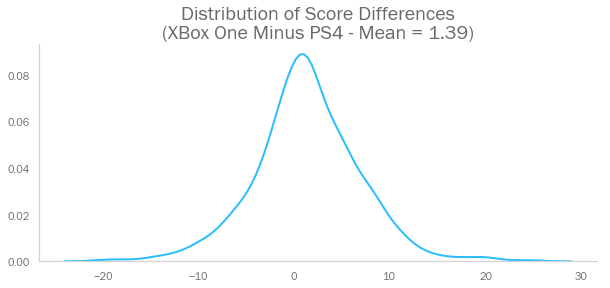

In [9]:
xb1_ps4 = score_diff('xboxone', 'ps4')

plt.figure(figsize=(10,4))

sns.kdeplot(xb1_ps4, lw=2)

# plt.plot(np.linspace(-20, 30, 2000),
#         [stats.norm.pdf(i,
#                         loc=np.array(xb1_ps4).mean(),
#                         scale=np.array(xb1_ps4).std())
#          for i in np.linspace(-20, 30, 2000)],
#         color='red', lw=1, ls='--')

plt.ylim(0)

plt.legend([], frameon=False)

diff_mean = round(xb1_ps4.mean(),2)
plt.title(f'Distribution of Score Differences\n(XBox One Minus PS4 - Mean = {diff_mean})');

In [10]:
def t_stat(sample, mu=0):
    
    '''
    Takes a sample and returns its t-statistic
    relative to an assumed population mean
    '''
    
    X = np.array(sample)
    
    X_bar = X.mean()
    s = X.std()
    n = len(X)

    return (X_bar - mu) / (s / n**0.5)



def plot_tdist(dof, alpha=0.05,
               width=10, size=(9,5), one_sided=True):
    
    Xs = np.linspace(-width/2, width/2, 200*width)
    Ys = stats.t.pdf(Xs, dof, 0, 1)
    
    plt.figure(figsize=size)
    plt.plot(Xs, Ys, lw=3)
    
    if one_sided == True:
        t_crit = stats.t.ppf(1-alpha, df=dof)
        t_area = np.linspace(t_crit, width/2, 200*width)

        plt.fill_between(t_area,
                         stats.t.pdf(t_area, dof, 0, 1),
                         [0 for i in t_area],
                         color=CB91_Pink,
                         label='T-Critical Area')
        
    if one_sided == False:
        t_crit = stats.t.ppf(1-(alpha/2), df=dof)
        t_area = np.linspace(t_crit, width/2, 200*width)

        plt.fill_between(t_area,
                         stats.t.pdf(t_area, dof, 0, 1),
                         [0 for i in t_area],
                         color=CB91_Pink,
                         label='T-Critical Area')
        
        plt.fill_between(-1*t_area,
                         stats.t.pdf(t_area, dof, 0, 1),
                         [0 for i in t_area],
                         color=CB91_Pink)
    
    plt.xlim(-width/2, width/2)
    plt.ylim(0);
    
    
    
def plot_ttest(sample, mu=0, alpha=0.05,
               width=20, size=(9,4), one_sided=True):
    
    dof = len(sample)-1
    
    plot_tdist(dof, alpha, width, size, one_sided=one_sided)
    
    sample_t_stat = t_stat(sample, mu=mu)
    
    plt.axvline(sample_t_stat, color='red',
                lw=2, ls='--',
                label='T-Statistic')
    
    plt.legend(frameon=False)

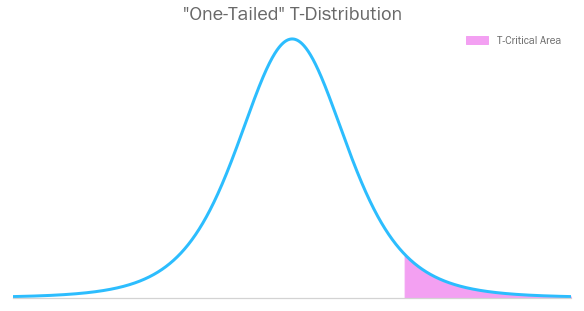

In [11]:
plot_tdist(5, alpha=0.05,
           width=10, size=(10,5), one_sided=True)

plt.xticks([])
plt.yticks([])
sns.despine(left=True)
plt.legend(frameon=False)
plt.title('"One-Tailed" T-Distribution');

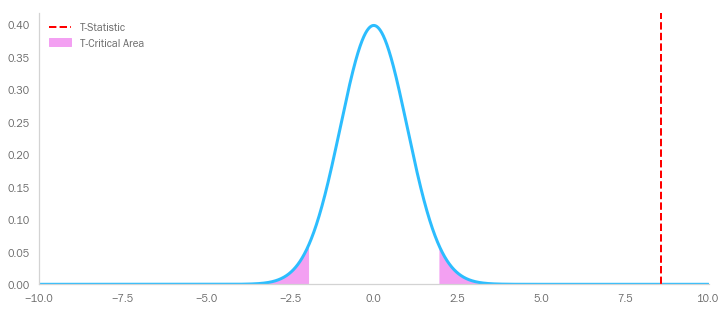

In [12]:
plot_ttest(xb1_ps4, size=(12,5), one_sided=False)

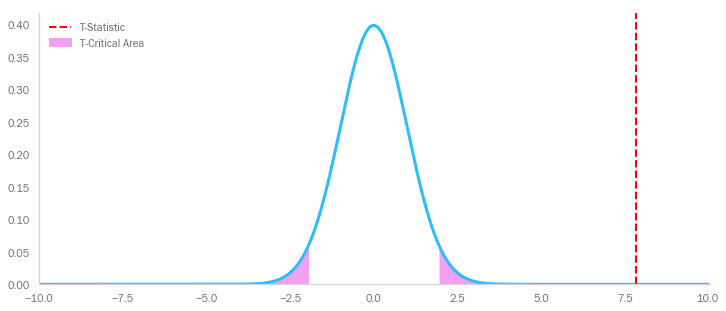

In [13]:
plot_ttest(score_diff('xboxone', 'switch'), size=(12,5), one_sided=False)

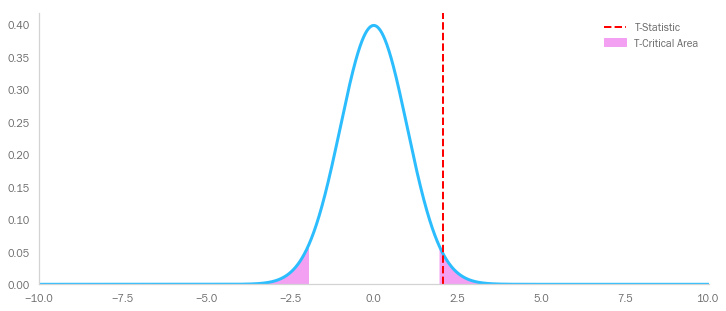

In [14]:
plot_ttest(score_diff('ps4', 'switch'), size=(12,5), one_sided=False)

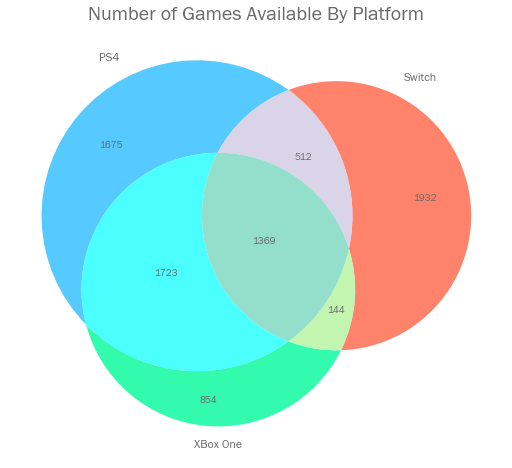

In [15]:
plt.figure(figsize=(12,8))

console_sets = [set(df_ps4['GameTitle']),
                set(df_switch['GameTitle']),
                set(df_xbox['GameTitle'])]

venn3(console_sets,
      ('PS4', 'Switch', 'XBox One'),
      set_colors = (CB91_Blue, 'tomato', 'mediumspringgreen'),
      alpha=0.8)

plt.title('Number of Games Available By Platform');

# Who has the best exclusives?

In [16]:
def exclusives(platform):
    platforms = ['ps4','xboxone','switch']
    other = list(filter(lambda x: x!=platform, platforms))
    
    df_temp = df_score.pivot_table(values='MetaRating',
                               index='GameTitle',
                               columns='Platform')
    
    sample = df_temp.loc[(df_temp[other[0]].isnull())
                         &(df_temp[other[1]].isnull())][platform]
    
    return np.array(sample)

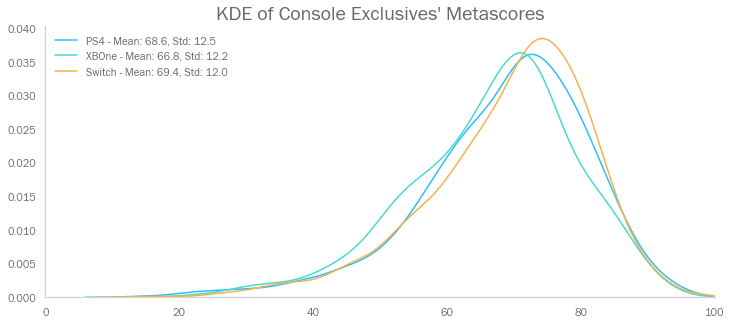

In [17]:
excl_p = exclusives('ps4')
excl_x = exclusives('xboxone')
excl_s = exclusives('switch')

plt.figure(figsize=(12,5))
sns.kdeplot(excl_p, label=f'PS4 - Mean: {round(excl_p.mean(),1)}, Std: {round(excl_p.std(),1)}')
sns.kdeplot(excl_x, label=f'XBOne - Mean: {round(excl_x.mean(),1)}, Std: {round(excl_x.std(),1)}')
sns.kdeplot(excl_s, label=f'Switch - Mean: {round(excl_s.mean(),1)}, Std: {round(excl_s.std(),1)}')

plt.xlim(0,100)
plt.legend(frameon=False, loc=2)
plt.title("KDE of Console Exclusives' Metascores");

## Set hypothesis

* H0: XBox >= PS4 
* Ha: XBox < PS4

Let's work with an alpha level of 0.05.

In [18]:
def welch_t(a, b):
    
    """
    Calculate Welch's t-statistic for two samples.
    """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

In [19]:
welch_t(excl_p, excl_x)

2.425440665090851

In [34]:
def welch_dof(a, b):
    
    """
    Calculate the effective degrees of freedom for two samples.
    """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


def welch_p_value(sample1, sample2):
    
    dof = welch_dof(sample1, sample2)
    t = welch_t(sample1, sample2)

    return 1 - stats.t.cdf(t, dof)



def plot_welch_ttest(sample1, sample2, alpha=0.05,
                     width=20, size=(9,4)):
    
    dof = welch_dof(sample1, sample2)
    
    plot_tdist(dof, alpha, width, size)
    
    welch_t_stat = welch_t(sample1, sample2)
    
    plt.axvline(welch_t_stat, color='red',
                lw=2, ls='--',
                label='T-Statistic')
    
    plt.legend(frameon=False)

In [36]:
print(welch_p_value(excl_p, excl_x))
print(welch_p_value(excl_x, excl_s))
print(welch_p_value(excl_p, excl_s))

0.007766864969350973
0.0002968668861861312
0.09522883144757266


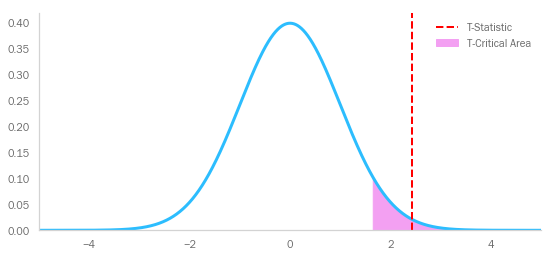

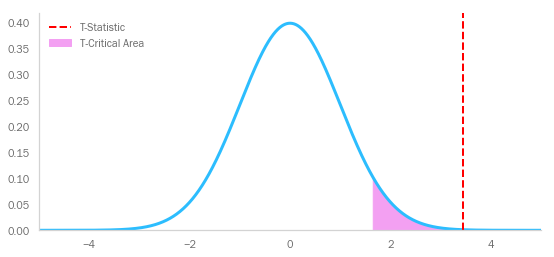

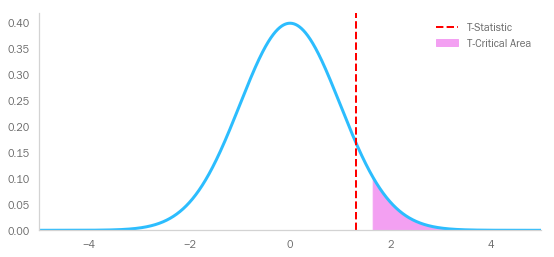

In [21]:
plot_welch_ttest(excl_p, excl_x, width=10, alpha=0.05)
plot_welch_ttest(excl_x, excl_s, width=10, alpha=0.05)
plot_welch_ttest(excl_p, excl_s, width=10, alpha=0.05)

In [22]:
def subtract_list(full_list, sub_list, return_as_array=True):
    
    '''
    Take one list (full_list),
    and "remove" another (sub_list) from it.
    
    e.g. subtract_list([1,1,3,5,5,6,7], [1,5,6])
         returns [1,3,5,7]
         
    sub_array must be a sub-set of the full_array
    '''
    #Ensure that inputs are lists
    if type(full_list) != list:
        full_list = list(full_list)
        
    if type(sub_list) != list:
        sub_list = list(sub_list)
    
    #Create a deepcopy of the sub_list to avoid unintended
    #effects of remove function
    sub = copy.deepcopy(sub_list)
    
    #Use a list comprehension to remove the elements
    #in the sublist from the full list
    new_list = [i for i in full_list if i not in sub or sub.remove(i)]
    
    #Cast as array if we need to, before returning
    if return_as_array == True:
        return np.array(new_list)
    else:
        return new_list
    
    
    
def monte_carlo(A, B, n = 10000, A_x_than_B = 'greater'):
    
    '''
    Run a monte carlo simulation on two samples, and return a p_value
    that the mean of population A is bigger than population B
    
    INPUTS:
        A (numpy array or list):
        The first sample (the one we expect to be larger)

        B (numpy array or list):
        The second sample (the one we expect to be smaller)

        n (integer):
        The number of simulations that should be run
        
        A_x_than_B (string):
        -'greater' if we are testing that A is greater than B
        -'less' if we are testing that A is less than B
    '''
    
    #Test to see if samples are given as lists, and convert to numpy arrays if so:
    if type(A) == list:
        A = np.array(A)
    if type(B) == list:
        B = np.array(B)
        
    #Calculate the true mean difference for comparison later
    mean_diff = np.mean(A) - np.mean(B)
    
    #Combine the two samples into a single array
    data = np.concatenate((A, B))
    
    #Instantiate a list of samples with same length as sample B
    new_Bs = []
    
    #Take n random samples equal to length of sample B from the combined array
    for i in range(n):
        new_Bs.append(np.random.choice(data, len(B), replace=False))
    
    #Given our list of new_B samples, create an equivalent list of new_As.
    #These are the 'complimentary sets' of elements, relative to the new_Bs.
    new_As = [subtract_list(data, i) for i in new_Bs]
    
    #Create a list of these new combinations
    new_combs = [(new_As[i], new_Bs[i]) for i in range(n)]
    
    #Calculate the differences between their means
    comb_diffs = np.array([np.mean(i[0]) - np.mean(i[1]) for i in new_combs])
    
    #Work out the share of the comb_diffs that are larger or smaller than the original mean_diff
    if A_x_than_B == 'greater':
        return sum(comb_diffs > mean_diff) / n
    if A_x_than_B == 'less':
        return sum(comb_diffs < mean_diff) / n

In [26]:
monte_carlo(excl_p, excl_x)

0.0079

In [27]:
monte_carlo(excl_s, excl_p)

0.0962

In [28]:
monte_carlo(excl_s, excl_x)

0.0003

In [29]:
def ks_test(X):
    '''
    Takes a distribution X, assumes that it is normal.
    Thus, transforms it to a standard normal, and performs
    Kolmogorov-Smirnov test, returning p-value of H0
    (high value means likely that distribtion is indeed normal)
    '''
    
    #Make sure distribution is in an array
    if type(X) == list:
        X = np.array(X)
    
    #Calculate the mean and standard deviation
    mu = X.mean()
    s = X.std()
    
    #Standardise the data
    X_normed = (X-mu) / s
    
    #Perform the KS test
    test = stats.kstest(X_normed, 'norm')
    
    #Return the required p-value
    return test[1]

In [30]:
ks_test(excl_p)

5.937403391020388e-06

In [31]:
ks_test(excl_x)

0.011435737802738469

In [32]:
ks_test(excl_s)

4.4409178595252647e-07